엑셀 파일 만들기

In [45]:
import xml.etree.ElementTree as ET
import csv
import os

def get_label_number(label):
    if label == "normal":
        return 1
    elif label == "crckles":
        return 2
    elif label == "wheezes":
        return 3
    else:
        return 0  # 다른 라벨은 0으로 처리

# CSV 파일을 열고 CSV writer 객체 생성
with open('/home/sogaksa123/AIFFEL_THON/model/SSD300/train.csv', 'w', newline='') as csvfile:  # 출력할 CSV 파일명
    writer = csv.writer(csvfile)

    # CSV 파일의 헤더 작성
    writer.writerow(['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])

    # XML 파일들이 있는 디렉터리 설정
    xml_dir = '/home/sogaksa123/AIFFEL_THON/model/SSD300/dataset/train/xml'  # XML 파일들이 있는 디렉터리명
    xml_files = os.listdir(xml_dir)

    # 각 XML 파일에 대해 처리
    for xml_file in xml_files:
        # XML 파일을 파싱하여 데이터 추출
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        # 파일 이름 추출
        file_name = xml_file.split('.')[0] + '.png'  # 확장자를 제외한 파일명

        # XML에서 객체 정보를 추출하여 CSV 파일에 쓰기
        for obj in root.findall('object'):
            label = obj.find('name').text
            label_number = get_label_number(label)
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)

            # CSV 파일에 한 행으로 쓰기
            writer.writerow([file_name, xmin, xmax, ymin, ymax, label_number])


In [1]:
import sys
sys.path.append('/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/')

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

In [4]:
img_height = 224
img_width = 224
img_channels = 3

intensity_mean = 127.5
intensity_range = 127.5

n_classes = 3
scales = [0.08, 0.16, 0.32, 0.64, 0.96]
aspect_ratios = [0.5, 1.0, 2.0]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [1.0, 1.0, 1.0, 1.0]
normalize_coords = True

In [5]:
K.clear_session()

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

In [6]:
# model.load_weights('/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/ssd7_weights.h5')

adam = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

/home/sogaksa123/anaconda3/envs/sogaksa/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [7]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

In [8]:
images_dir = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/png_file'

train_labels_filename = '/home/sogaksa123/AIFFEL_THON/model/SSD300/train.csv'
val_labels_filename   = '/home/sogaksa123/AIFFEL_THON/model/SSD300/val.csv'

In [9]:
train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')


In [10]:
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  2084
Number of images in the validation dataset:	   595


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ identity_layer      │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mean_normali… │ (None, 224, 224,  │          0 │ identity_layer[0… │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stddev_norma… │ (None, 224, 224,  │          0 │ input_mean_norma… │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 224, 224,  │      2,432 │ input_stddev_nor… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 224, 224,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu1 (ELU)          │ (None, 224, 224,  │          0 │ bn1[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 112, 112,  │          0 │ elu1[0][0]        │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 112, 112,  │     13,872 │ pool1[0][0]       │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 112, 112,  │        192 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu2 (ELU)          │ (None, 112, 112,  │          0 │ bn2[0][0]         │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 56, 56,    │          0 │ elu2[0][0]        │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 56, 56,    │     27,712 │ pool2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 56, 56,    │        256 │ conv3[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu3 (ELU)          │ (None, 56, 56,    │          0 │ bn3[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 28, 28,    │          0 │ elu3[0][0]        │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4 (Conv2D)      │ (None, 28, 28,    │     36,928 │ pool3[0][0]     

 Total params: 200,048 (781.44 KB)

 Trainable params: 199,376 (778.81 KB)

 Non-trainable params: 672 (2.62 KB)

In [12]:
predictor_sizes = [(30,30),(15,15),(7,7),(3,3)]

In [13]:
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

In [14]:
train_generator = train_dataset.generate(batch_size=16,
                                         shuffle=True,
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False
                                        )

val_generator = val_dataset.generate(batch_size=16,
                                     shuffle=False,
                                     transformations=[],
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False
                                     )

In [15]:
model_checkpoint = ModelCheckpoint(filepath='ssd7_weights.keras',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             early_stopping,
             reduce_learning_rate]

In [16]:
def train(model):
    initial_epoch = 0
    final_epoch = 20
    steps_per_epoch = 1000
    batch_size = 16


    history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=final_epoch,
                                callbacks=callbacks,
                                validation_data=val_generator,
                                validation_steps=ceil(val_dataset_size/batch_size),
                                initial_epoch=initial_epoch)



    plt.figure(figsize=(20, 12))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right', prop={'size': 24})

    return model

Predictions

In [17]:
predict_generator = val_dataset.generate(batch_size=16,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [18]:
batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/png_file/183_1b1_Pl_sc_Meditron_1.png

Ground truth boxes:

[[  1   0  56  77 218]
 [  2  77  56 224 218]]


In [19]:
y_pred = model.predict(batch_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


In [20]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred * 266.,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 1.00e+00  2.63e+02 -5.87e+08      -inf -5.87e+08       inf]
 [ 2.00e+00  2.52e+02      -inf      -inf       inf       inf]
 [ 2.00e+00  2.27e+02  8.02e+08 -3.87e+08  8.02e+08 -3.87e+08]
 [ 3.00e+00  2.64e+02      -inf -4.28e+09       inf -4.28e+09]]


/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/ssd_encoder_decoder/ssd_output_decoder.py:175: RuntimeWarning: overflow encountered in exp
  y_pred_decoded_raw[:,:,[-2,-1]] = np.exp(y_pred_decoded_raw[:,:,[-2,-1]] * y_pred[:,:,[-2,-1]]) # exp(ln(w(pred)/w(anchor)) / w_variance * w_variance) == w(pred) / w(anchor), exp(ln(h(pred)/h(anchor)) / h_variance * h_variance) == h(pred) / h(anchor)
/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/bounding_box_utils/bounding_box_utils.py:280: RuntimeWarning: invalid value encountered in multiply
  return side_lengths[:,0] * side_lengths[:,1]
/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/bounding_box_utils/bounding_box_utils.py:378: RuntimeWarning: invalid value encountered in multiply
  boxes1_areas = (boxes1[:,xmax] - boxes1[:,xmin] + d) * (boxes1[:,ymax] - boxes1[:,ymin] + d)
/home/sogaksa123/AIFFEL_THON/model/SSD300/TF_Keras_SSD/bounding_box_utils/bounding_box_utils.py:379: RuntimeWarning: invalid value encountered in mul

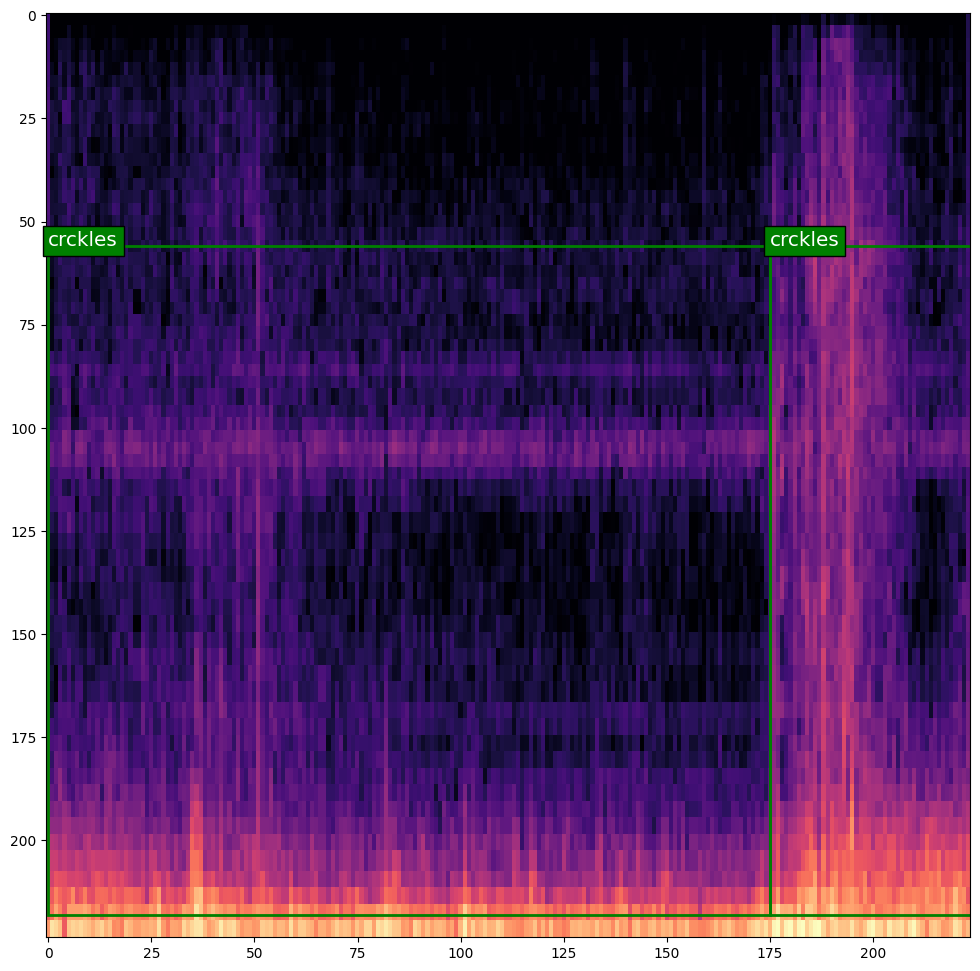

In [27]:
plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['normal', 'crckles','wheezes']

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])-2])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])-2], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  